# 14 - Extracting a sourcelist

This is a notebook example of how to grab aperture summed spectra for an input list of ID, RA, DECs using `Extract()` from `HETDEX_API`. An array of wavelengths is optional for this notebook in case you would like to inspect spectra around a specific wavelength. Eventually we can make this a command line routine. The notebook here is for developing and testing. Contact Erin with questions and isssues.

#### Import all necessary python packages. 
For those using Python3, it is necessary to point to the HETDEX_API path. You can either use Erin's or your own git clone if you prefer.

In [2]:
import sys
sys.path.append('/work/05350/ecooper/stampede2/HETDEX_API/') 

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
import pickle

from input_utils import setup_logging
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.table import Table
from hetdex_api.extract import Extract
from hetdex_api.survey import Survey
from hetdex_api.shot import *

# modules for multiprocessing, timing and manager shared dictionaries
from multiprocessing import Pool, Process, Manager
import time

log = setup_logging('3dhst')
log.info('Loading Survey')
survey = Survey('hdr1')
t = Table(survey.hdfile.root.Survey[:])

[INFO - 2019-09-16 14:56:37,995] Loading Survey


Load in a text file, map columns accordingly and build an astropy coords object.

In [4]:
log.info('Loading External File')
#table_in = Table.read('/work/04312/wpbowman/stampede2/catalogs/bowman2019_full.dat', format='ascii')
table_in = Table.read('/work/05350/ecooper/stampede2/3dhst/3dhst_input.cat', format='ascii')

log.info('Sources to extract: %s' % np.size(table_in))
ID = table_in['photID']
ra = table_in['ra']
dec = table_in['dec']

## for line fitting later.. not necessary for basic aperture extraction
wave = table_in['wave']

coords = SkyCoord(ra*u.deg, dec*u.deg)

[INFO - 2019-09-16 14:56:38,022] Loading External File
[INFO - 2019-09-16 14:56:38,029] Sources to extract: 1282


### Initialize the Extract Class from HETDEX_API and set up some initial parameters

In [5]:
E = Extract()

# Build aperture PSF for aperture extraction
fixed_aperture = 4.

# this radius applies to the inital shot search and requires a large aperture for the wide FOV of VIRUS
max_sep = 11.0 * u.arcminute

# Using box size of 10.5 (length of box side) and pixel scale of 0.25
# To see documentation use: help(E.tophat_psf)
aperture = E.tophat_psf(fixed_aperture, 10.5, 0.25)

Begin by mapping each source to each shot so we can efficiently grab fibers. This stores a dictionary of object indexes for each observation as well as a list of shots to iterate over.

In [6]:
matched_sources = {}
shots_of_interest = []

log.info('Finding shots of interest')
for i, coord in enumerate(survey.coords):
    dist = coords.separation(coord)
    sep_constraint = dist < max_sep
    name = '%sv%03d' % (t['date'][i], t['obsid'][i])
    idx = np.where(sep_constraint)[0]
    matched_sources[name] = idx
    if len(idx) > 0:
        shots_of_interest.append(name)
log.info('Number of shots of interest: %i' % len(shots_of_interest))

[INFO - 2019-09-16 14:56:43,110] Finding shots of interest
[INFO - 2019-09-16 14:56:44,953] Number of shots of interest: 149


Define the function to extract the aperture summed spectra for each relevent observation. It takes a sources dictionary initialized by the multiprocesses Manager Class and an observation ID in the form datevobs (ie. '20180123v009'). The Sources dictionary is shared among all processes. It contains for each input source ID, a dictionary for each observation containing the source spectra, spectra uncertainty and weights.

In [7]:
def get_source_spectra(source_dict, datevobs):

        if len(matched_sources[datevobs]) > 0:
            log.info('Working on shot: %s' % datevobs)
            E.load_shot(datevobs)
        
            for ind in matched_sources[datevobs]:
                info_result = E.get_fiberinfo_for_coord(coords[ind], radius=7.)
                if info_result is not None:
                    log.info('Extracting %s' % ID[ind])
                    ifux, ifuy, xc, yc, ra, dec, data, error, mask = info_result
                    weights = E.build_weights(xc, yc, ifux, ifuy, aperture)
                    result = E.get_spectrum(data, error, mask, weights)
                    spectrum_aper, spectrum_aper_error = [res for res in result]
                    if ID[ind] in source_dict:
                        source_dict[ID[ind]][datevobs] = [spectrum_aper, spectrum_aper_error, weights.sum(axis=0)]
                    else:
                        source_dict[ID[ind]] = manager.dict()
                        source_dict[ID[ind]][datevobs] = [spectrum_aper, spectrum_aper_error, weights.sum(axis=0)] 
            E.fibers.close()

### Multiprocessing Magic

Here we use python's multiprocessing package to distribute the Extraction process of each shot across all available cores.

In [ ]:
# Initialize the manager to manage the shared dictionary of output
manager = Manager()

# output dictionary of spectra for each observation
Sources = manager.dict()

start = time.time()
jobs = [ Process(target=get_source_spectra, args=(Sources, datevobs)) 
       for datevobs in shots_of_interest
       ]
for j in jobs:
    j.start()
for j in jobs:
    j.join()
end = time.time()
log.info( 'Extraction of sources completed in %.2f minutes.' % ((end-start)/60.))

In [ ]:
log.info( 'Extraction of sources completed in %.2f minutes.' % ((end-start)/60.))

In [9]:
# Sources stored in this nested dictionary: first keys are ID.. next keys are datevobs
print(Sources[28317])
# get list of arrays of spec, spece, weights using:
# Sources[obj][datevobs]

{'20170221v016': [array([nan, nan, nan, ..., nan, nan, nan]), array([nan, nan, nan, ..., nan, nan, nan]), array([0.56904296, 0.56880146, 0.56856022, ..., 0.42406066, 0.4240354 ,
       0.42401043])], '20170322v011': [array([nan, nan, nan, ..., nan, nan, nan]), array([nan, nan, nan, ..., nan, nan, nan]), array([0.94593157, 0.94593605, 0.94594071, ..., 0.94282542, 0.94282459,
       0.94282384])], '20170327v012': [array([nan, nan, nan, ..., nan, nan, nan]), array([nan, nan, nan, ..., nan, nan, nan]), array([0.9463835 , 0.94639873, 0.94641543, ..., 0.94581244, 0.94581748,
       0.94582247])], '20170322v019': [array([nan, nan, nan, ..., nan, nan, nan]), array([nan, nan, nan, ..., nan, nan, nan]), array([0.94488795, 0.94489208, 0.94489583, ..., 0.94361989, 0.94361398,
       0.94360808])]}


## Now let's do some line fitting (this will not apply to continuum sources)

In [10]:
#install specutils if you haven't already
#! pip3 install specutils --user 
#
from astropy.modeling import models
from specutils import Spectrum1D, SpectralRegion
from specutils.analysis import equivalent_width
from specutils.fitting import estimate_line_parameters
from specutils.manipulation import extract_region

In [11]:
def line_fit(obj, datevobs):
    spectrum = Spectrum1D( flux = Sources[obj][datevobs][1]*u.erg * u.cm**-2 / u.s / u.AA, 
                        spectral_axis=E.wave*u.AA)
    
    wave_obj = wave[obj == ID][0]

    sub_region = SpectralRegion((wave_obj-10)*u.AA, (wave_obj+10)*u.AA)
    
    sub_spectrum = extract_region(spectrum, sub_region)

    line_param =  estimate_line_parameters(sub_spectrum, models.Gaussian1D())
  
    if (line_param.amplitude.value > 0) & (line_param.fwhm.value <10):
        plt.figure()
        plt.plot(spectrum.spectral_axis, spectrum.flux)
        plt.title('ID: '+ str(obj) + '   ObsID: '+ str(datevobs))
        plt.xlim([ wave_obj - 25, wave_obj + 25])
        plt.xlabel('Spectral Axis ({})'.format(spectrum.spectral_axis.unit))
        plt.ylabel('Flux Axis({})'.format(spectrum.flux.unit))
        plt.savefig('spec_' + str(obj) + '_' + str(datevobs) + '.png')
        #plt.ylabel('1e-17 ergs/s/cm^2/A')

/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: invalid value encountered in greater
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/home1/05350/ecooper/.local/lib/python3.7/site-packages/astropy/units/quantity.py:464: RuntimeWarning: invalid value encountered in less_equal
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
/opt/apps/intel18/python3/3.7.0/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


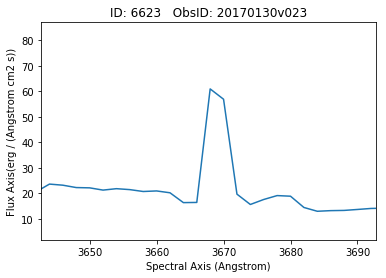

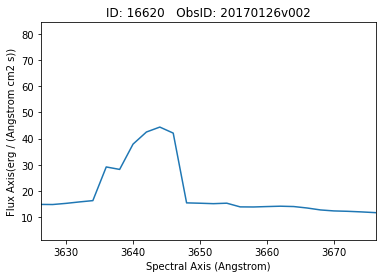

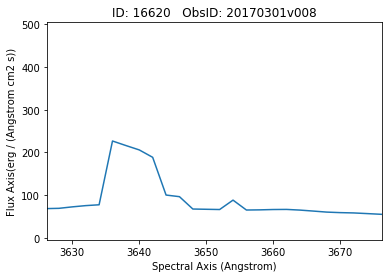

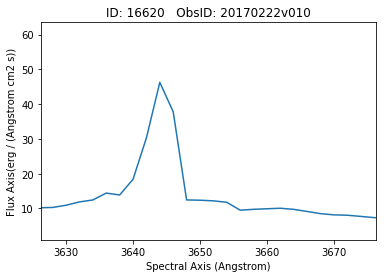

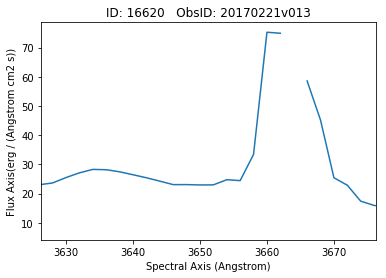

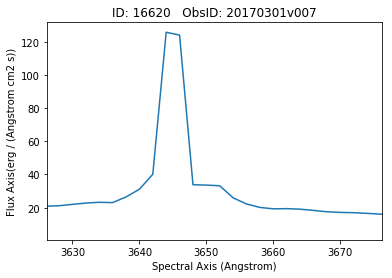

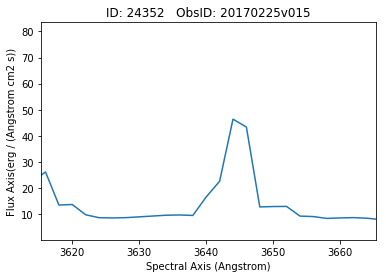

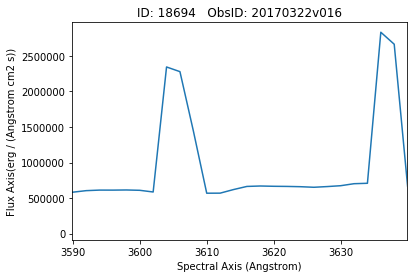

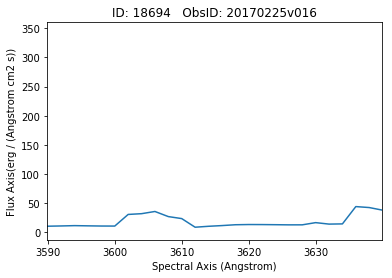

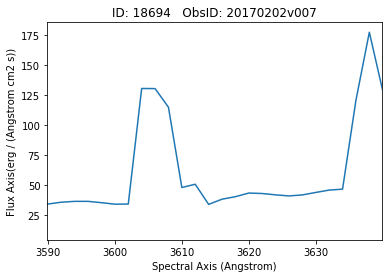

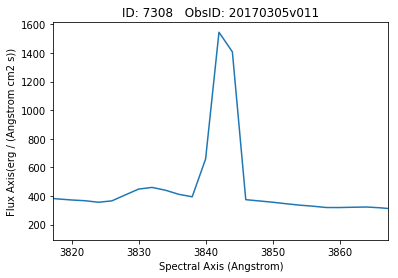

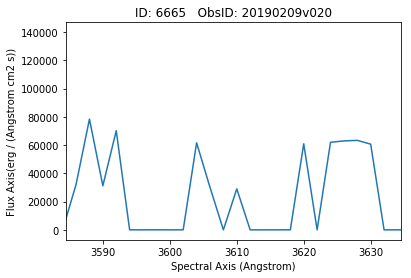

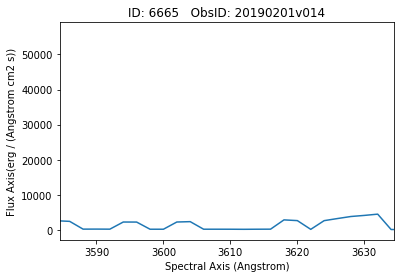

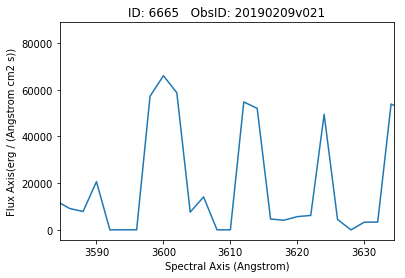

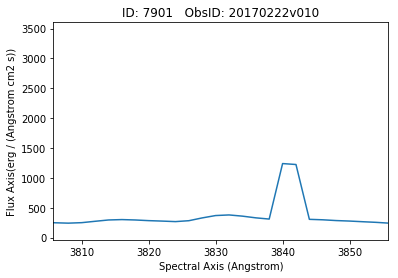

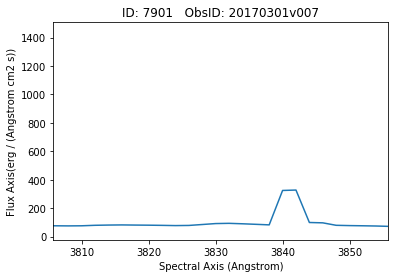

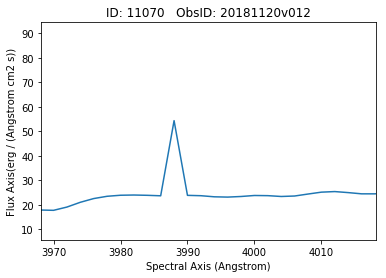

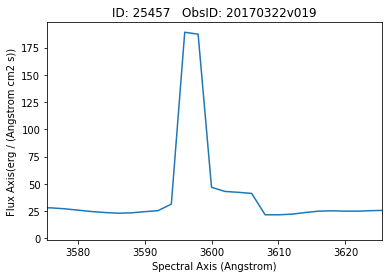

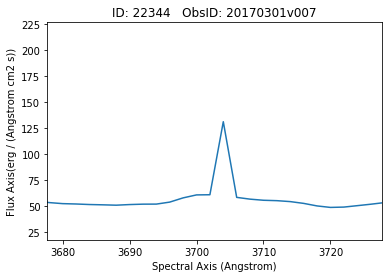

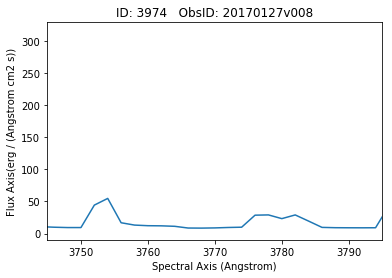

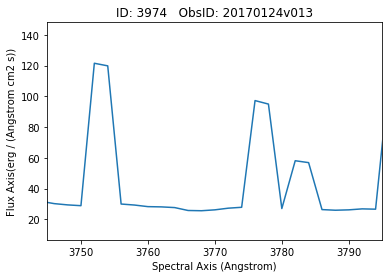

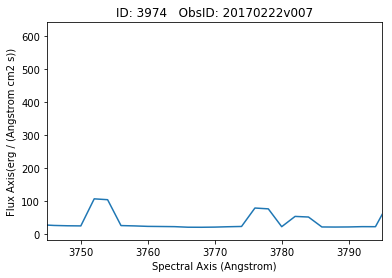

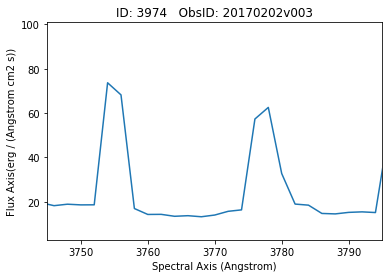

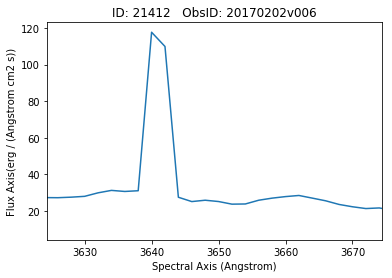

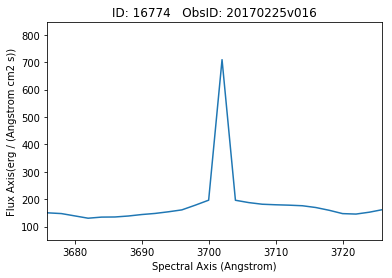

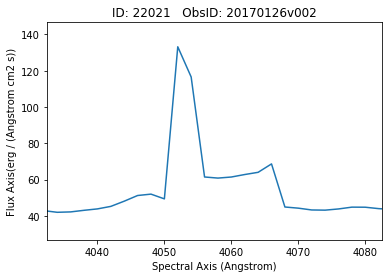

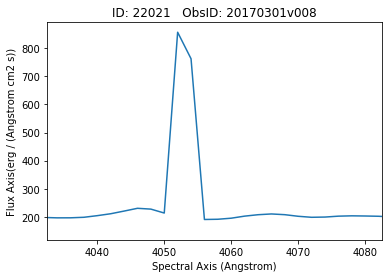

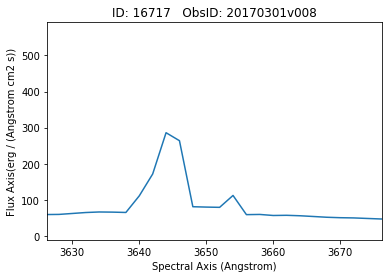

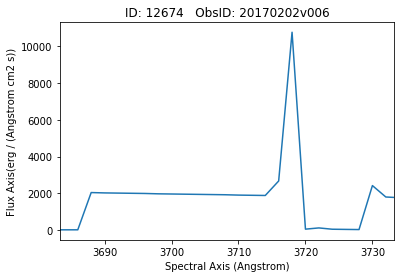

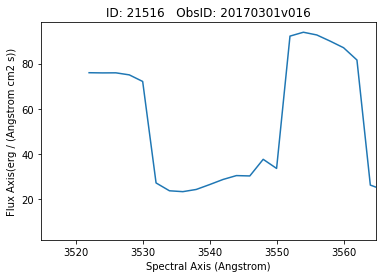

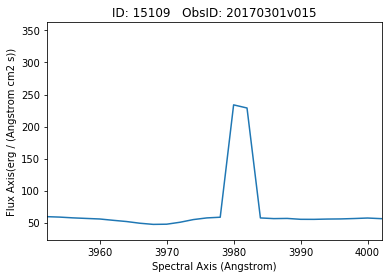

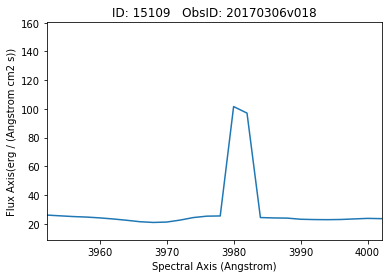

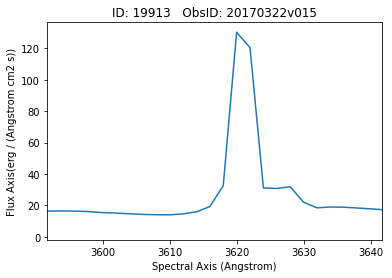

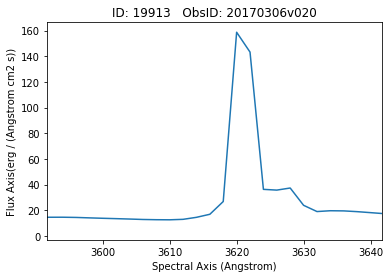

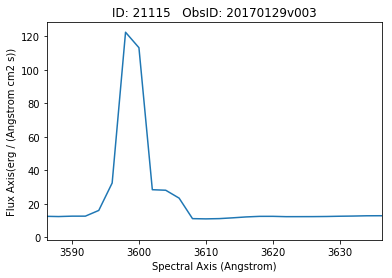

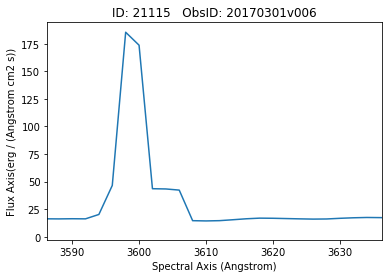

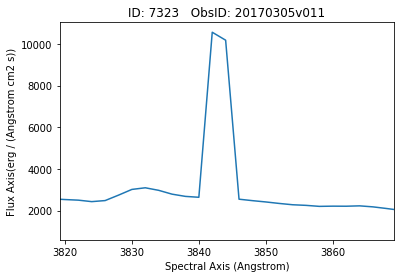

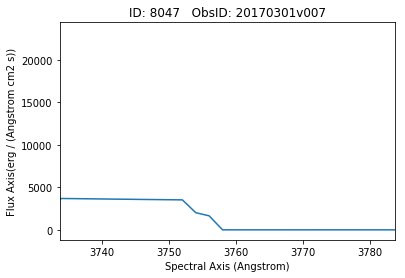

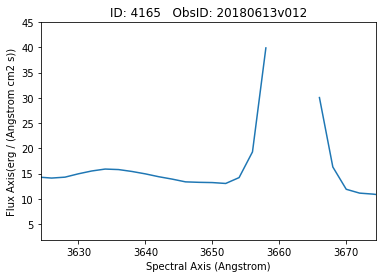

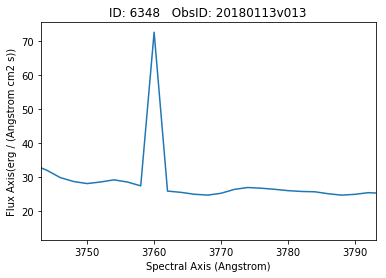

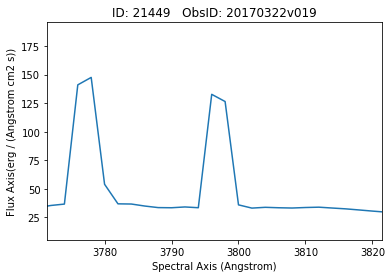

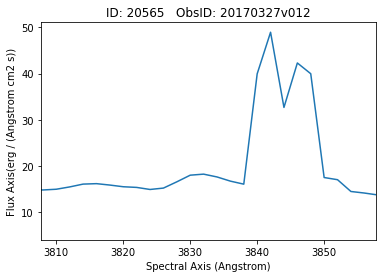

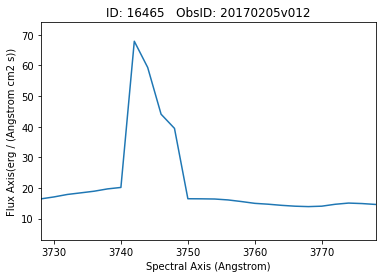

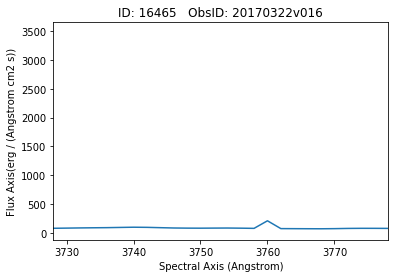

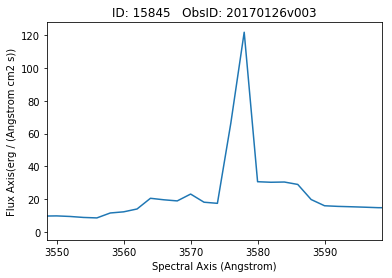

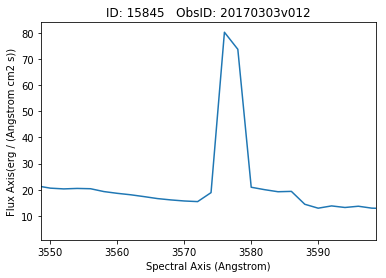

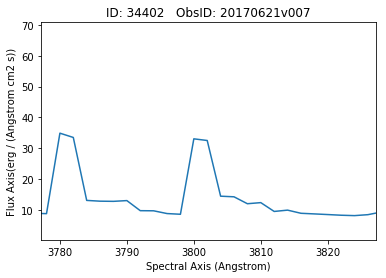

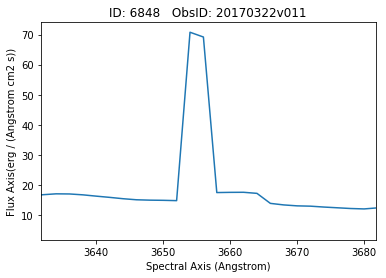

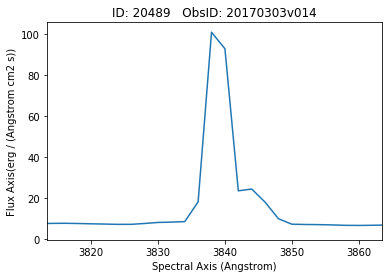

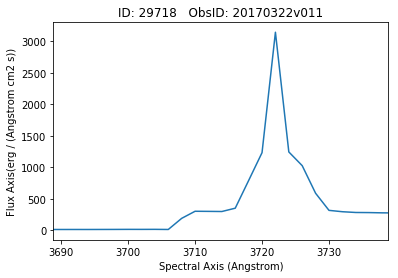

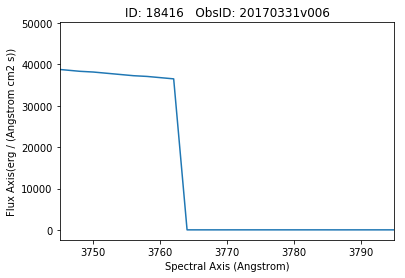

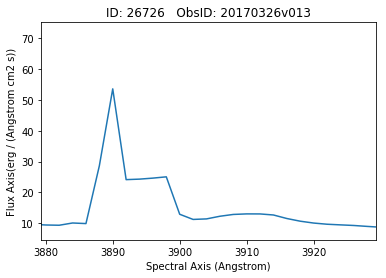

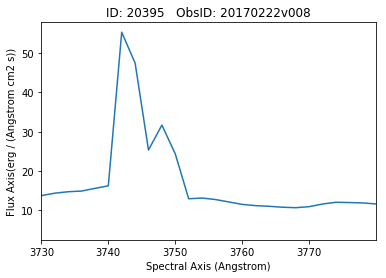

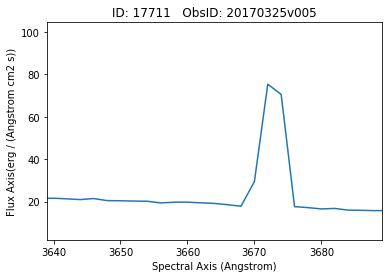

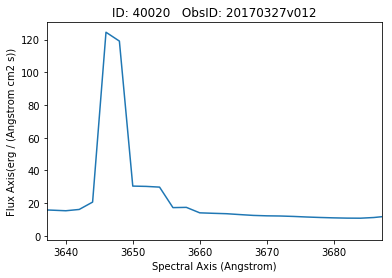

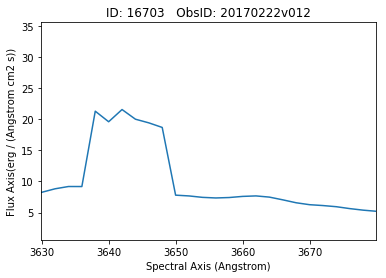

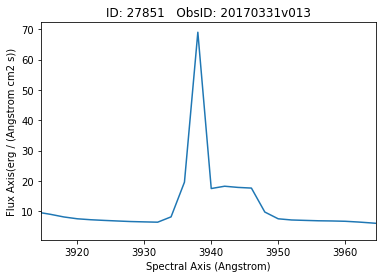

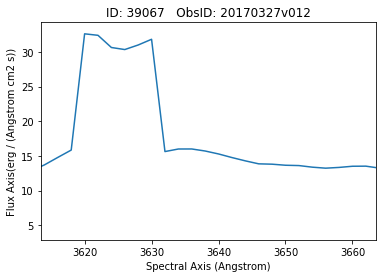

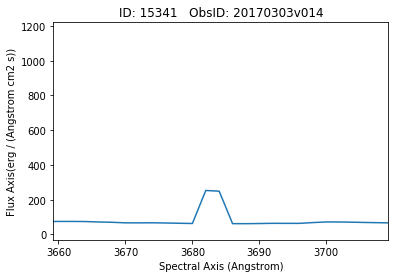

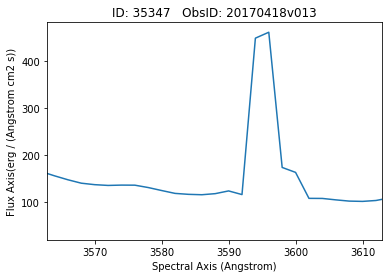

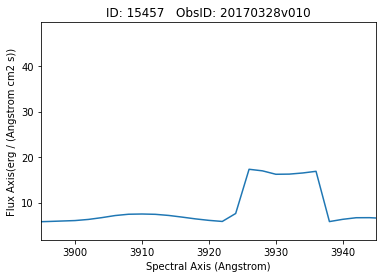

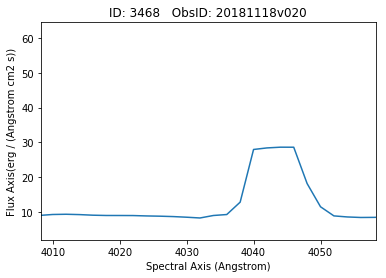

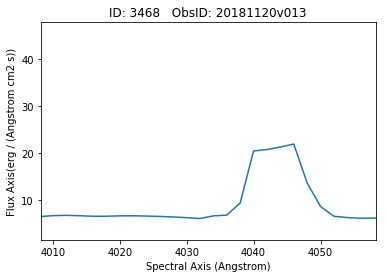

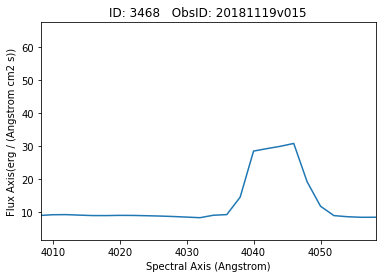

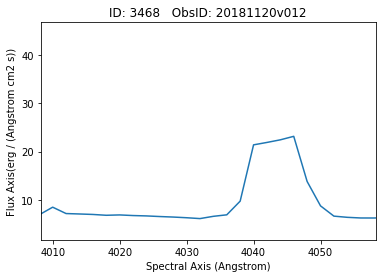

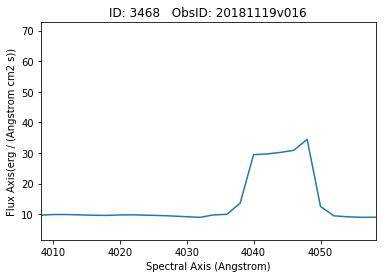

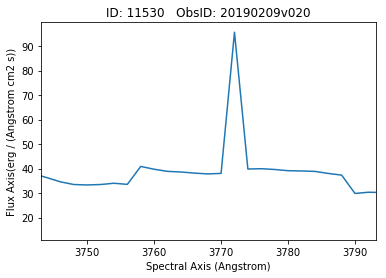

In [12]:
count = 0
for obj in Sources.keys():
    for datevobs in Sources[obj].keys():
        count += 1
        line_fit( obj, datevobs) # note could use multiprocessing Pool to really speed this up

In [17]:
log.info("Source dictionary contains %s extractions" % count)

[INFO - 2019-07-05 11:43:47,748] Source dictionary contains 5233 extractions
INFO:input_utils:Source dictionary contains 5233 extractions
